# SGD VS MiniBatchSGD VS RMSProp

In [73]:
import numpy as np
from typing import Callable
from numpy.typing import NDArray


class SGD:
    def __init__(self, n_epochs: int = 50, alpha: float = 0.01):
        if n_epochs <= 0 or not isinstance(n_epochs, int):
            raise ValueError("'n_epochs' must be positive int number.")
        self.n_epochs = n_epochs
        
        if alpha < 0 or not isinstance(alpha, (int, float)):
            raise ValueError("'alpha' must be non-negative number.")
        self.alpha = alpha


    def solve(self, f_batch: Callable, grad_f_single: Callable, x0: NDArray, X: NDArray, y: NDArray) -> tuple[NDArray, list]:
        """ 
        The method to find solution of minimizing function 'f' with gradient 'grad_f_single' and initial guess 'x0'.
        """
        xk = x0.copy()
        n_samples = X.shape[0]
        history = []

        for _ in range(self.n_epochs):
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            for i in range(n_samples):
                xk -= self.alpha * grad_f_single(xk, X_shuffled[i], y_shuffled[i])

            history.append(f_batch(xk))
        return xk, history
        

Let's maximize likelihood function which is equivalent to minimize cross-entropy ( multiply log-likelihood by $-1/N$) in binary classification problem ($X$ - features, $Y$ - class label, $\hat{Y}$ - predictions by sigmoid).

likelihood function: $ L(w) = \prod_{i=1}^N \hat{y_i}^{y_i}  (1-\hat{y_i})^{1-y_i}$, $w$ - sigmoid weights

cross-entropy loss: $ J(w) = -\frac{1}{N} \sum_{i=1}^N \left( y_i log(\hat{y_i}) + (1-y_i) log(1-\hat{y_i})\right) $

$\nabla J(w) = \frac{1}{N} X^T (\hat{Y} - Y)$

Estimation for weights: [ 8.62976178  3.22433062 -1.42085658]
True weights: [3, 1, 0]


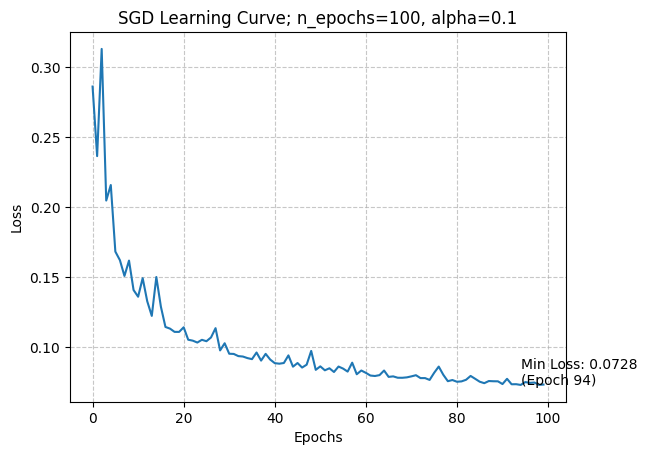

In [74]:
import numpy as np
np.random.seed(666)

N = 50
X = np.random.normal(loc=[-1,3], scale=[1,2**0.5], size=(N,2))
eps = np.random.normal(loc=0,scale=0.1**0.5,size=N)
Y = (3*X[:,0] + X[:,1] + eps > 0).astype(int)


X = np.hstack((X, np.ones((N, 1))))

sigmoid_batch = lambda w: 1 / (1 + np.exp(-X @ w))
sigmoid_single = lambda w, xi: 1 / (1 + np.exp(- np.dot(xi, w)))
cross_entropy_batch = lambda w: -np.mean(Y * np.log(sigmoid_batch(w) + 1e-15) + (1 - Y) * np.log(1 - sigmoid_batch(w) + 1e-15))
grad_cross_entropy_single = lambda w, xi, yi, : xi * (sigmoid_single(w, xi) - yi)

w0 = np.ones(shape=3)
n_epochs = 100; alpha = 0.1
w_hat, loss_history = SGD(n_epochs=n_epochs, alpha=alpha).solve(cross_entropy_batch, grad_cross_entropy_single, w0, X, Y)
print(f"Estimation for weights: {w_hat}")
print(f"True weights: {[3,1,0]}")

import matplotlib.pyplot as plt
plt.plot(loss_history)
min_epoch = int(np.argmin(loss_history))
min_loss = loss_history[min_epoch]
plt.annotate(
    text=f'Min Loss: {min_loss:.4f}\n(Epoch {min_epoch})',
    xy=(min_epoch, min_loss),
    xytext=(min_epoch, min_loss)                           
)

plt.title(f'SGD Learning Curve; {n_epochs=}, {alpha=}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

So, despite the chaotic nature of the descent direction, SGD shows a consistent decrease in the objective functional (loss function). As result for 100 epochs solver outputs the next estimations of weights:
- $\hat{w_0} = 8.62976178$, with true value of 3
- $\hat{w_1} = 3.22433062$, with true value of 1
- $\hat{b} = -1.42085658$ (bias) with true value of 0

Actually, its quite good results because $\hat{w_0}:\hat{w_1}=2.67:1$ as we want to keep ratio $w_0:w_1=3:1$. Also, value of loss function quite small, only 0.07. But it can be improved. Let's try to tune algorithm using mini-batch strategy.

### Mini-Batch Gradient Descent
Actually, Mini-batch gradient descent (MBGD) - its kind of compromise between default batch gradient descent (grdaient for whole dataset at each step) and SGD (gradient per single data point at each step) by splitting the training data into small batches.

Mini-Batch Weights: [ 4.52233969  1.63031115 -0.23638349]
Pure SGD Weights:   [ 8.61269933  3.25694751 -1.44288969]
True weights ratio: ~3.0
MB Ratio: 2.77


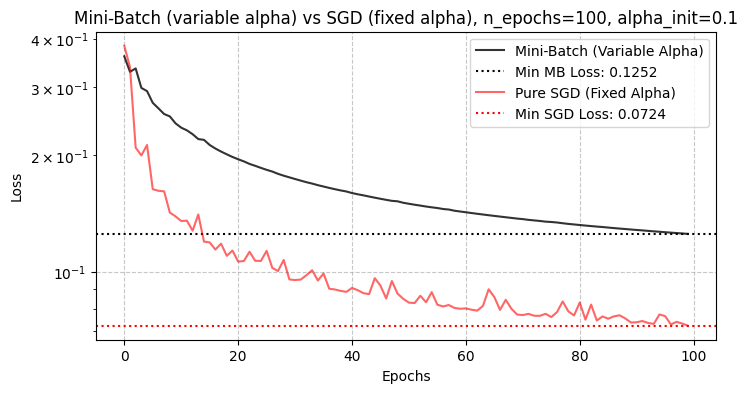

Mini-Batch Weights: [ 9.83553522  3.73703717 -1.70320123]
Pure SGD Weights:   [35.06095615 14.68426543 -8.81963683]
True weights ratio: ~3.0
MB Ratio: 2.63


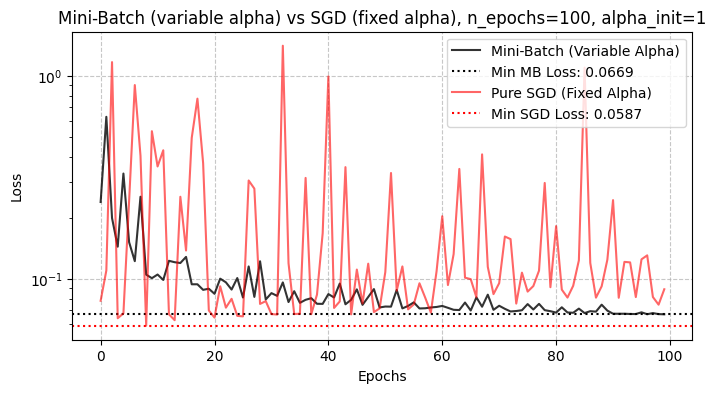

In [ ]:
import numpy as np
np.random.seed(666)
from typing import Callable
import matplotlib.pyplot as plt
from numpy.typing import NDArray


class MiniBatchSGD:
    def __init__(self, n_epochs: int = 50, init_alpha: float = 0.1, batch_size: int = 32, decay: float = 0.0):
        if n_epochs <= 0 or not isinstance(n_epochs, int):
            raise ValueError("'n_epochs' must be positive int number.")
        self.n_epochs = n_epochs
        
        if init_alpha < 0 or not isinstance(init_alpha, (int, float)):
            raise ValueError("'alpha' must be non-negative number.")
        self.init_alpha = init_alpha
        
        if batch_size <= 0 or not isinstance(batch_size, int): 
            raise ValueError("'batch_size' must be positive int number")
        self.batch_size = batch_size
        
        if not isinstance(decay, (int, float)):
            raise ValueError("'decay' must be a number.")
        self.decay = decay

    def solve(self, f: Callable, grad_f_batch: Callable, x0: NDArray, X: NDArray, y: NDArray) -> tuple[NDArray, list[float]]:
        xk = x0.copy()
        n_samples = X.shape[0]
        history = []

        for epoch in range(self.n_epochs):
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            current_alpha = self.init_alpha / (1 + self.decay * epoch)
            for i in range(0, n_samples, self.batch_size):
                X_batch = X_shuffled[i : i + self.batch_size]
                y_batch = y_shuffled[i : i + self.batch_size]
                grad = grad_f_batch(xk, X_batch, y_batch)
                
                xk -= current_alpha * grad

            history.append(f(xk))            
        return xk, history


N = 50
X = np.random.normal(loc=[-1, 3], scale=[1, 2**0.5], size=(N, 2))
eps = np.random.normal(loc=0, scale=0.1**0.5, size=N)
Y = (3 * X[:, 0] + X[:, 1] + eps > 0).astype(int)

X = np.hstack((X, np.ones((N, 1))))


sigmoid = lambda w, X_batch: 1 / (1 + np.exp(-X_batch @ w))
cross_entropy = lambda w: -np.mean(Y * np.log(sigmoid(w, X) + 1e-15) + (1 - Y) * np.log(1 - sigmoid(w, X) + 1e-15))
grad_cross_entropy = lambda w, X_batch, Y_batch: 1/len(Y_batch) * X_batch.T @ (sigmoid(w, X_batch) - Y_batch)

w0 = np.ones(shape=3)
for n_epochs, alpha_init in [(100, 0.1), (100, 1)]:

    solver_mb = MiniBatchSGD(n_epochs=n_epochs, init_alpha=alpha_init, batch_size=5, decay=0.01)
    w_hat_mb, history_mb = solver_mb.solve(cross_entropy, grad_cross_entropy, w0, X, Y)

    solver_sgd = MiniBatchSGD(n_epochs=n_epochs, init_alpha=alpha_init, batch_size=1, decay=0.0)
    w_hat_sgd, history_sgd = solver_sgd.solve(cross_entropy, grad_cross_entropy, w0, X, Y)


    print(f"Mini-Batch Weights: {w_hat_mb}")
    print(f"Pure SGD Weights:   {w_hat_sgd}")
    print(f"True weights ratio: ~3.0")
    print(f"MB Ratio: {w_hat_mb[0]/w_hat_mb[1]:.2f}")

    plt.figure(figsize=(8, 4))

    plt.plot(history_mb, label='Mini-Batch (Variable Alpha)', color='#000000', alpha=0.8)
    min_mb = np.min(history_mb)
    plt.axhline(min_mb, color='#000000', linestyle=':', label=f'Min MB Loss: {min_mb:.4f}')

    plt.plot(history_sgd, label='Pure SGD (Fixed Alpha)', color='#FF0000', alpha=0.6)
    min_sgd = np.min(history_sgd)
    plt.axhline(min_sgd, color='#FF0000', linestyle=':', label=f'Min SGD Loss: {min_sgd:.4f}')

    plt.title(f'Mini-Batch (variable alpha) vs SGD (fixed alpha), {n_epochs=}, {alpha_init=}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.yscale('log')
    plt.legend()
    plt.show()

Heh, mixed results. Let's analyze them one by one.

First of all, for clarity, I demonstrated optimization for two different initial alphas. This comparison allows us to see the usefulness of alpha decay. 

With a high fixed step size, SGD becomes chaotic. It makes rapid progress initially but overshoots the minimum, resulting in fail of stable converge. In case of MiniBatchSGD, averaging gradients over a batch inherently reduces noise, and the decaying learning rate acts as a brake, allowing the algorithm to settle into the minimum smoothly despite the aggressive start. It achieves a comparable final loss to SGD but with much higher stability.

For lower value of alpha, SGD is much better. Because it updates the weights 50 times per epoch (once per sample) compared to Mini-Batch's 5 updates (once per batch of 10), it effectively learns "faster" in terms of epochs. The fixed step size is small enough to avoid divergence but large enough to keep descending quickly. While MBGD is too conservative for that case. The combination of fewer updates per epoch and a decaying learning rate causes it to slow down. It ends up with a higher loss because it simply hasn't taken enough effective steps to reach the bottom.

In general, Mini-Batch approximates the true direction better.

### RMSProp
Unlike previous algorithms, RMSProp adapts the learning rate for each parameter separately. It divides the gradient by the moving average of the previous gradients. This reduces fluctuations in directions with a large gradient and speeds up movement where the gradient is small.

$ E[g^2](t) = \beta E[g^2](t-1) + (1-\beta) \left( \frac{\partial c}{\partial w}\right)^2$

$w_{ij}(t)=w_{ij}(t-1) - \frac{\alpha}{E[g^2]} \frac{\partial c}{\partial w_{ij}}$

where $E[g]$ is the moving average of squared gradients, $\frac{\partial c}{\partial w}$ is gradient of the cost function with respect to the weight, $\alpha$ is the learning rate and $\beta$ is moving average parameter (default value — 0.9, to make the sum of default gradient value 0.1 on nine mini-batches and -0.9 on tenths is approximate zero, and the default value $\alpha$ is 0.001 as per experience).

Pure SGD Weights:   [ 8.36331954  3.20170821 -1.36166461]
Mini-Batch Weights: [ 8.83522469  3.38170284 -1.4810775 ]
RMSProp Weights: [16.52497085  6.40377098 -3.25560147]
True weights ratio: ~3.0
MB Ratio: 2.61
RMSProp Ratio: 2.58


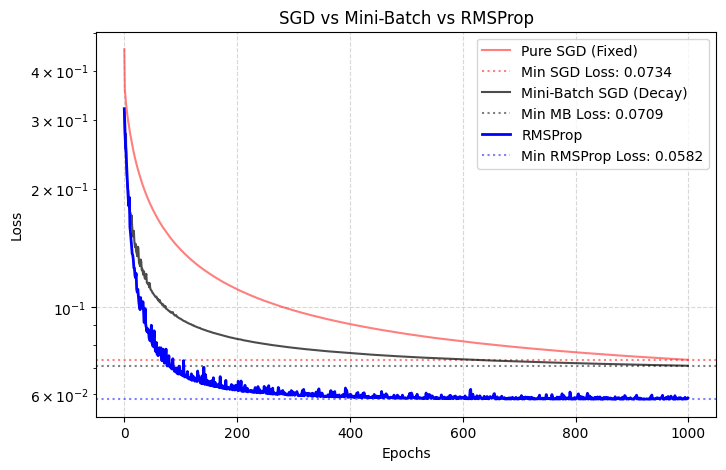

In [107]:
import numpy as np
np.random.seed(666)
from typing import Callable
import matplotlib.pyplot as plt
from numpy.typing import NDArray


class RMSProp:
    def __init__(self, n_epochs: int = 50, alpha: float = 0.001, batch_size: int = 32, beta: float = 0.9):
        if n_epochs <= 0 or not isinstance(n_epochs, int):
            raise ValueError("'n_epochs' must be positive int number.")
        self.n_epochs = n_epochs
        
        if alpha < 0 or not isinstance(alpha, (int, float)):
            raise ValueError("'alpha' must be non-negative number.")
        self.alpha = alpha
        
        if batch_size <= 0 or not isinstance(batch_size, int): 
            raise ValueError("'batch_size' must be positive int number")
        self.batch_size = batch_size
        
        if beta < 0 or not isinstance(beta, (int, float)):
            raise ValueError("'beta' must be non-negative number.")
        self.beta = beta
        
        self._epsilon = 1e-8

    def solve(self, f: Callable, grad_f_batch: Callable, x0: NDArray, X: NDArray, y: NDArray) -> tuple[NDArray, list[float]]:
        xk = x0.copy()
        n_samples = X.shape[0]
        history = []
        
        E = np.zeros_like(xk)

        for _ in range(self.n_epochs):
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            for i in range(0, n_samples, self.batch_size):
                X_batch = X_shuffled[i : i + self.batch_size]
                y_batch = y_shuffled[i : i + self.batch_size]
                
                grad = grad_f_batch(xk, X_batch, y_batch)
                E = self.beta * E + (1 - self.beta) * (grad ** 2)
                xk -= (self.alpha / (np.sqrt(E) + self._epsilon)) * grad

            history.append(f(xk))            
        return xk, history


N = 50
X = np.random.normal(loc=[-1, 3], scale=[1, 2**0.5], size=(N, 2))
eps = np.random.normal(loc=0, scale=0.1**0.5, size=N)
Y = (3 * X[:, 0] + X[:, 1] + eps > 0).astype(int)

X = np.hstack((X, np.ones((N, 1))))


sigmoid = lambda w, X_batch: 1 / (1 + np.exp(-X_batch @ w))
cross_entropy = lambda w: -np.mean(Y * np.log(sigmoid(w, X) + 1e-15) + (1 - Y) * np.log(1 - sigmoid(w, X) + 1e-15))
grad_cross_entropy = lambda w, X_batch, Y_batch: 1/len(Y_batch) * X_batch.T @ (sigmoid(w, X_batch) - Y_batch)

n_epochs = 1000

sgd_solver = MiniBatchSGD(n_epochs=n_epochs, init_alpha=0.01, batch_size=1, decay=0.0)
w_sgd, hist_sgd = sgd_solver.solve(cross_entropy, grad_cross_entropy, w0, X, Y)

mb_solver = MiniBatchSGD(n_epochs=n_epochs, init_alpha=0.5, batch_size=10, decay=0.01)
w_mb, hist_mb = mb_solver.solve(cross_entropy, grad_cross_entropy, w0, X, Y)

rms_solver = RMSProp(n_epochs=n_epochs, alpha=0.1, batch_size=10, beta=0.9)
w_rms, hist_rms = rms_solver.solve(cross_entropy, grad_cross_entropy, w0, X, Y)

print(f"Pure SGD Weights:   {w_sgd}")
print(f"Mini-Batch Weights: {w_mb}")
print(f"RMSProp Weights: {w_rms}")
print(f"True weights ratio: ~3.0")
print(f"MB Ratio: {w_mb[0]/w_mb[1]:.2f}")
print(f"RMSProp Ratio: {w_rms[0]/w_rms[1]:.2f}")

plt.figure(figsize=(8, 5))
plt.plot(hist_sgd, label='Pure SGD (Fixed)', color='#FF0000', alpha=0.5)
plt.axhline(np.min(hist_sgd), color='#FF0000', linestyle=':', alpha=0.5, label=f"Min SGD Loss: {np.min(hist_sgd):.4f}")
plt.plot(hist_mb, label='Mini-Batch SGD (Decay)', color='#000000', alpha=0.7)
plt.axhline(np.min(hist_mb), color='#000000', linestyle=':', alpha=0.5, label=f"Min MB Loss: {np.min(hist_mb):.4f}")
plt.plot(hist_rms, label='RMSProp', color='#0000FF', linewidth=2)
plt.axhline(np.min(hist_rms), color='#0000FF', linestyle=':', alpha=0.5,  label=f"Min RMSProp Loss: {np.min(hist_rms):.4f}")
plt.title(f'SGD vs Mini-Batch vs RMSProp')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

Obviously, RMSProp is the clear winner, significantly outperforming both Mini-Batch and Pure SGD. It achieved a minimum loss of 0.0582, compared to ~0.07 for the others. The RMSProp's curve drops in the first few epochs, reaching a low loss almost instantly, while SGD and Mini-Batch descend slower.

Notice that RMSProp found weights twice as large as the others. In Logistic Regression, higher weights create a sharper decision boundary (steeper sigmoid), which reduces Cross-Entropy loss for separable data. Standard SGD with a fixed/decaying step size moves too slowly to reach these high magnitudes efficiently, while RMSProp normalizes the gradient, maintaining momentum.

### Conclusion:
In this study, we investigated various stochastic optimization algorithms to solve a binary classification problem using logistic regression. The goal was to overcome the inefficiencies of classical descent methods on large-scale problems.

While SGD speeds up the process by calculating gradients for single examples, it follows a chaotic route. With a high fixed learning rate, it suffers from volatility and overshooting, failing to converge stably. However, with a lower learning rate, it can be computationally efficient due to the high frequency of updates.

Implementing mini-batches with learning rate decay significantly improved stability by reducing gradient noise. While it approximates the true direction of the weight vector better than pure SGD , it can be too conservative; if the learning rate decays too quickly, the algorithm slows down prematurely and fails to reach the true minimum.

RMSProp proved to be the most effective, significantly outperforming both SGD and Mini-Batch strategies. By adapting the learning rate for each parameter separately, RMSProp achieved the lowest loss (0.0582) and fastest convergence.

So, while Mini-Batch SGD offers a compromise between stability and speed, RMSProp is the top choice for this type of optimization problem. Its ability to normalize gradients and maintain momentum allows it to navigate the loss landscape efficiently and reach a deeper minimum.

References:
- https://optimization.cbe.cornell.edu/index.php?title=Stochastic_gradient_descent
- https://optimization.cbe.cornell.edu/index.php?title=RMSProp